In [1]:
import numpy as np
import random
import pathlib
import copy
import os
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import manhattan_distances
from itertools import chain
from pprint import pprint
from tqdm import tqdm
from math import sqrt, floor

W1 = 1
W2 = 5000

In [2]:
def sets_paths(set_name, dir_path=''):
    path_to_files = dir_path + f"Vrp-Set-{set_name}/" + f'{set_name}/'
    files = os.listdir(path_to_files)
    list_solutions_filenames = []
    list_vpr_filenames = []
    for file in files:
        if file.endswith('.sol'):
            list_solutions_filenames.append(file)
        elif file.endswith('.vrp'):
            list_vpr_filenames.append(file)
    list_vpr_filenames.sort()
    list_solutions_filenames.sort()
    for vpr_file, sol_file in zip(list_vpr_filenames, list_solutions_filenames):
        assert vpr_file[:-4] == sol_file[:-4], f"f1_{vpr_file} != f2_{sol_file}"
    return list_vpr_filenames, list_solutions_filenames

In [3]:
SET_PROBLEMS = 'E'
vpr_paths, ans_paths = sets_paths(SET_PROBLEMS)
pprint(vpr_paths)

['E-n101-k14.vrp',
 'E-n101-k8.vrp',
 'E-n22-k4.vrp',
 'E-n23-k3.vrp',
 'E-n30-k3.vrp',
 'E-n33-k4.vrp',
 'E-n51-k5.vrp',
 'E-n76-k10.vrp',
 'E-n76-k14.vrp',
 'E-n76-k7.vrp',
 'E-n76-k8.vrp']


In [4]:
def read_vpr_file(file_name, set_name, dir_path=''):
    path_to_files = dir_path + f"Vrp-Set-{set_name}/" + f'{set_name}/' + file_name
    data = {}
    with open(path_to_files, 'r') as f:
        for i in range(6):
            curr_str = f.readline()
            name, atr = curr_str.strip().split(' : ')
            if name in {'DIMENSION', 'CAPACITY'}:
                data[name] = int(atr)
            else:
                data[name] = atr
        name_key = f.readline().strip()
        if name_key != 'NODE_COORD_SECTION':
            raise 'Something wrong'
        dict_node_coords = {}
        for _ in range(data['DIMENSION']):
            ind, x, y = map(int, f.readline().strip().split(' '))
            dict_node_coords[ind] =  (x, y)
        data[name_key] = dict_node_coords

        name_key = f.readline().strip()
        if name_key != 'DEMAND_SECTION':
            raise 'Something wrong'
        dct_demand_sections = {}
        for _ in range(data['DIMENSION']):
            ind, demand = map(int, f.readline().strip().split(' '))
            dct_demand_sections[ind] = demand
        data[name_key] = dct_demand_sections

        name_key = f.readline().strip()
        if name_key != 'DEPOT_SECTION':
            raise 'Something wrong'
        x = int(f.readline())
        y = int(f.readline())
        data[name_key] = (x, y)
        if f.readline().strip() != 'EOF':
            raise 'Something wrong'
    return data

def read_solution_file(file_name, set_name, dir_path=''):
    path_to_files = dir_path + f"Vrp-Set-{set_name}/" + f'{set_name}/' + file_name
    data = {}
    with open(path_to_files, 'r') as f:
        flag = True
        ls_routs = []
        while flag:
            line = f.readline().strip()
            if line == "":
                break
            if line.startswith('Route #'):
                parsed = line.split(": ")
                index = int(parsed[0].split("#")[1])
                route = list(map(int,(parsed[1].split())))
                ls_routs.append((index, route))
            elif line.startswith('Cost'):
                key, val = line.split(' ')
                data[key] = int(val)
                flag = False
            else:
                raise 'Something wrong'
        data['Route'] = ls_routs
        return data


In [5]:
index = 3
print(vpr_paths[index]," <---> ",ans_paths[index], sep='')
data = read_vpr_file(vpr_paths[index], SET_PROBLEMS)
solution = read_solution_file(ans_paths[index], SET_PROBLEMS)

E-n23-k3.vrp <---> E-n23-k3.sol


In [6]:
pprint(data)

{'CAPACITY': 4500,
 'COMMENT': '(Christophides and Eilon, Min no of trucks: 3, Optimal value: '
            '569)',
 'DEMAND_SECTION': {1: 0,
                    2: 125,
                    3: 84,
                    4: 60,
                    5: 500,
                    6: 300,
                    7: 175,
                    8: 350,
                    9: 150,
                    10: 1100,
                    11: 4100,
                    12: 225,
                    13: 300,
                    14: 250,
                    15: 500,
                    16: 150,
                    17: 100,
                    18: 250,
                    19: 120,
                    20: 600,
                    21: 500,
                    22: 175,
                    23: 75},
 'DEPOT_SECTION': (1, -1),
 'DIMENSION': 23,
 'EDGE_WEIGHT_TYPE': 'EUC_2D',
 'NAME': 'E-n23-k3',
 'NODE_COORD_SECTION': {1: (266, 235),
                        2: (295, 272),
                        3: (301, 258),
              

In [7]:
def split_into_routs(data, customer_order, car_capacity):
    lst_routs = []
    curr_route = []
    route_capacity_load = 0
    for curr_id in customer_order:
        curr_capacity = data['DEMAND_SECTION'][curr_id]
        if route_capacity_load + curr_capacity > car_capacity:
            lst_routs.append(curr_route)
            curr_route = [curr_id]
            route_capacity_load = curr_capacity
        else:
            curr_route.append(curr_id)
            route_capacity_load += curr_capacity
    if curr_route:
        lst_routs.append(curr_route)
    return lst_routs

def initialize_population_random(population_size, data):
    populations = []
    for _ in range(population_size):
        castomers_order = random.sample(range(2, data['DIMENSION'] + 1), data['DIMENSION'] - 1)
        routs = split_into_routs(data, castomers_order, data['CAPACITY'])
        populations.append(routs)
    return populations

def euclid_distance(coords_1, coords_2):
    if len(coords_1) != len(coords_2):
        raise ValueError()
    dist = sum([(x1-x2)**2 for x1, x2 in zip(coords_1, coords_2)])
    return (sqrt(dist))

def nearest_neighbor_init(data, car_capacity):
    remaining_customers = set(range(2, data['DIMENSION'] + 1))
    depot = data['DEPOT_SECTION'][0]
    curr_route = []
    while remaining_customers:
        if not curr_route:
            curr_route.append(depot)
        current_customer = min(remaining_customers, key=lambda c:
                               euclid_distance(data['NODE_COORD_SECTION'][curr_route[-1]], data['NODE_COORD_SECTION'][c]) 
                               if curr_route else float('inf'))
        curr_capacity = data['DEMAND_SECTION'][current_customer]
        if sum(data['DEMAND_SECTION'][c] for c in curr_route) + curr_capacity > car_capacity:
            curr_route.pop(0)
            yield curr_route
            curr_route = []
        else:
            curr_route.append(current_customer)
            remaining_customers.discard(current_customer)
    if curr_route:
        curr_route.pop(0)
        yield curr_route

def initialize_population_nearest_neighbor(population_size, data):
    populations = []
    neighbor_rout = list(nearest_neighbor_init(data, data['CAPACITY']))
    for _ in range(population_size):
        routes = [road.copy() for road in neighbor_rout]
        populations.append(routes)
    return populations

In [8]:
def calculate_total_distance(routes, data):
    total_dist = 0
    for car_road in routes:
        curr_car_dist = 0
        supply_point =  data['NODE_COORD_SECTION'][data['DEPOT_SECTION'][0]]
        prev_point = supply_point
        for curr_point in car_road:
            curr_point_xy = data['NODE_COORD_SECTION'][curr_point]
            curr_car_dist += euclid_distance(prev_point, curr_point_xy)
            prev_point = curr_point_xy
        curr_car_dist += euclid_distance(prev_point, supply_point)
        total_dist += curr_car_dist
    return total_dist

def calculate_capacity_fulfillment(individual, data, vehicle_capacity):
    capacity_penalty = 0
    for route in individual:
        route_demand = int(floor(sum(data['DEMAND_SECTION'][customer] for customer in route) + 0.5))
        if route_demand > vehicle_capacity:
            capacity_penalty += 1
    return capacity_penalty

def calculate_fitness(individual, data):
    total_distance = calculate_total_distance(individual, data)
    capacity_fulfillment = calculate_capacity_fulfillment(individual, data, data['CAPACITY'])
    fitness = W1 * total_distance + W2 * capacity_fulfillment    
    return fitness

def evaluate_population(population, data):
    fitness_lst = []
    for individual in population:
        fitnes = calculate_fitness(individual, data)
        fitness_lst.append(fitnes)
    return fitness_lst

def select_parents(population, fitness, size=None, temperature=1.0):
    fitness = np.reciprocal(fitness)
    roulette_wheel = fitness / np.sum(fitness)
    scaled_wheel = np.power(roulette_wheel, 1.0 / temperature)
    scaled_wheel /= np.sum(scaled_wheel)
    if size is None:
        size = len(population)
    selected_indices = np.random.choice(len(population), size=size, p=scaled_wheel)
    selected_parents = [[val.copy() for val in population[i]] for i in selected_indices]
    return selected_parents

In [9]:
def mutate(offspring, mutation_rate=0.3, mutation_type='combined'):
    ls = offspring
    for index in range(len(ls)):
        curr_ls = ls[index]
        if random.random() < mutation_rate:
            if mutation_type == 'insertion':
                apply_insertion_mutation(curr_ls)
            elif mutation_type == 'swap':
                apply_swap_mutation(curr_ls)
            elif mutation_type == 'split_route':
                apply_split_route_mutation(curr_ls)
            elif mutation_type == 'concatenate_routes':
                apply_concatenate_routes_mutation(curr_ls)
            elif mutation_type == 'combined':
                apply_combined_mutation(curr_ls)
            else:
                raise ValueError("Invalid mutation type")
    return ls

def apply_insertion_mutation(curr_ls):
    index_mutation = random.randrange(len(curr_ls))
    individual = curr_ls[index_mutation]
    gene_to_insert = random.choice(individual)
    individual.remove(gene_to_insert)
    insert_index = random.randrange(len(individual) + 1)
    individual.insert(insert_index, gene_to_insert)

def apply_swap_mutation(lsss):
    index1, index2 = random.sample(range(len(lsss)), 2)
    value1_index = random.randrange(len(lsss[index1]))
    value2_index = random.randrange(len(lsss[index2]))
    lsss[index1][value1_index], lsss[index2][value2_index] = lsss[index2][value2_index], lsss[index1][value1_index]
    return lsss

def apply_split_route_mutation(lsss):
    valid_indices = [i for i in range(len(lsss)) if len(lsss[i]) > 1]
    if not valid_indices:
        return lsss
    index = random.choice(valid_indices)
    split_position = random.randint(1, len(lsss[index]) - 1)
    subroute1 = lsss[index][:split_position]
    subroute2 = lsss[index][split_position:]
    lsss[index] = subroute1
    lsss.insert(index + 1, subroute2)
    return lsss

def apply_concatenate_routes_mutation(lsss):
    if len(lsss) <= 2:
        return
    index1, index2 = random.sample(range(len(lsss)), 2)
    route1_copy = lsss[index1].copy()
    concatenated_route = route1_copy + lsss[index2].copy()
    lsss[index1] = concatenated_route
    lsss.pop(index2)
    return lsss

def apply_reverse_mutation(curr_ls):
    index_mutation = random.randint(0, len(curr_ls) - 1)
    individual = curr_ls[index_mutation]
    if len(individual) <= 2:
        return curr_ls
    mutated_individual = individual.copy()
    point1, point2 = sorted(random.sample(range(len(mutated_individual)), 2))
    mutated_individual[point1:point2 + 1] = mutated_individual[point1:point2 + 1][::-1]
    curr_ls[index_mutation] = mutated_individual
    return curr_ls

def apply_combined_mutation(lsss):
    if random.random() < 0.5:
        if random.random() < 0.5:
            return apply_split_route_mutation(lsss)
        else:
            return apply_concatenate_routes_mutation(lsss)
    else:
        rand_val = random.random()
        if rand_val < 0.1:
            return apply_insertion_mutation(lsss)
        elif rand_val < 0.9:
            return apply_swap_mutation(lsss)
        else:
            return apply_reverse_mutation(lsss)

In [10]:
def replace_population(current_population, offspring, data, population_size=512):
    combined_population = current_population + offspring
    fitnesses_ = evaluate_population(combined_population, data)
    next_generation = select_next_generation(combined_population, fitnesses_, population_size)
    
    return next_generation

def select_next_generation(combined_population, fitnesses_, population_size=512):
    sorted_population = sorted(zip(combined_population, fitnesses_), key=lambda x: x[1])
    next_generation = [individual for individual, _ in sorted_population[:population_size]]
    return next_generation

In [11]:
def order_crossover(parent1, parent2):

    child_1 = [[-1] * len(i) for i in parent1]
    child_2 = [[-1] * len(i) for i in parent2]
    swap_index = min(len(parent2) - 1, random.randint(0, len(parent1) - 1))
    
    # Perform the swap for child_1
    child_1[swap_index] = parent1[swap_index].copy()
    set_c1_vals = set(parent1[swap_index])

    flattened_parent_2 = list(chain(*parent2))
    shift_amount = random.randint(0, len(flattened_parent_2) - 1)
    flattened_parent_2 = flattened_parent_2[shift_amount:] + flattened_parent_2[:shift_amount]

    index_iterator = 0
    for car_index, route in enumerate(child_1):
        for index, point_id in enumerate(route):
            if point_id == -1:
                while flattened_parent_2[index_iterator] in set_c1_vals:
                    index_iterator += 1
                child_1[car_index][index] = flattened_parent_2[index_iterator]
                set_c1_vals.add(flattened_parent_2[index_iterator])
                index_iterator += 1

    child_2[swap_index] = parent2[swap_index].copy()
    set_c2_vals = set(parent2[swap_index])
    
    flattened_parent_1 = list(chain(*parent1))
    shift_amount = random.randint(0, len(flattened_parent_1) - 1)
    flattened_parent_1 = flattened_parent_1[shift_amount:] + flattened_parent_1[:shift_amount]
        
    index_iterator = 0
    for car_index, route in enumerate(child_2):
        for index, point_id in enumerate(route):
            if point_id == -1:
                while flattened_parent_1[index_iterator] in set_c2_vals:
                    index_iterator += 1
                child_2[car_index][index] = flattened_parent_1[index_iterator]
                set_c2_vals.add(flattened_parent_1[index_iterator])
                index_iterator += 1
    
    return child_1, child_2


def crossover(selected_parents, prob):
    offspring = []
    for ii in range(len(selected_parents)):
        parent1_ind, parent2_ind = random.sample(range(0,len(selected_parents)),2) 
        parent1, parent2 = selected_parents[parent1_ind], selected_parents[parent2_ind]
        if random.random() < prob:
            child1, child2 = order_crossover(parent1, parent2)
        else:
            child1, child2 = [val.copy() for val in parent1], [val.copy() for val in parent2]
        offspring.extend([child1, child2])
    return offspring

In [12]:
def genetic_algorithm_cvrp(population_size, data, params = {
        "crossover_prob": 0.5,
        "mutation_rate": 0.3,
        "mutation_type": "combined",
        "neighbor_init": True,
        "min_iter": 1000,
        "max_iter": 2000,
        "logging": True,
        "num_parent_child_in_new_population": 20,
        "fitness_check_itter": 200,
        "fittnes_diff": 5,
        "sampling_temp": 2}
        ):
    if params["neighbor_init"]:
        population = initialize_population_nearest_neighbor(population_size, data)
    else:
        population = initialize_population_random(population_size, data)
    iterations = 0
    fittness_diff = float("+inf")
    prev_fites_value = None
    while iterations < params["min_iter"] or (params["fittnes_diff"] > params["fittnes_diff"] and iterations < params["max_iter"]) :
        # Evaluation
        fitness = evaluate_population(population, data)
        # Selection
        selected_parents = select_parents(population, fitness, size=None, temperature=params["sampling_temp"])
        # Crossover
        offspring = crossover(selected_parents, prob=params["crossover_prob"])
        # Mutation
        ofs = mutate(offspring, mutation_rate=params["mutation_rate"], mutation_type=params["mutation_type"])
        # Replacement
        population = replace_population(population[:params["num_parent_child_in_new_population"]], ofs, data, population_size)
        if iterations % params["fitness_check_itter"] == 0:
            fitnessxx = evaluate_population(population, data)
            # print(fitnessxx[:10])
            if params["logging"]:
                print("itter", iterations, "min_value=",fitnessxx[0])
            if prev_fites_value is None:
                prev_fites_value = fitnessxx[0]
            else:
                fittness_diff =  abs(fitnessxx[0] - prev_fites_value)
            prev_fites_value = fitnessxx[0]
        iterations +=1
    return population

In [19]:
def run(SET_PROBLEMS = "A", pop_size = 128):
    list_of_scores = []
    dct_res = {}
    vpr_paths, ans_paths = sets_paths(SET_PROBLEMS)
    for index in tqdm(range(len(vpr_paths))[::]):
        assert vpr_paths[index][:-4] == ans_paths[index][:-4]
        print(vpr_paths[index])
        data = read_vpr_file(vpr_paths[index], SET_PROBLEMS)
        solution = read_solution_file(ans_paths[index], SET_PROBLEMS)
        zzz = genetic_algorithm_cvrp(pop_size, data)        
        res = evaluete(zzz[0], data, solution['Cost'])
        print(f"result {round(res, 3)}")
        print('---')
        list_of_scores.append(res)
        dct_res[vpr_paths[index][:-4]] = round(res, 3)
    return (list_of_scores, dct_res , np.mean(list_of_scores))

def evaluete(rout, data, solution_cos):
    val = int(floor(calculate_total_distance(rout, data) + 0.5))
    print(f'Predicted = {val} optim = {solution_cos}')
    return ((val - solution_cos) / solution_cos)

In [25]:
results_A = run("A", 256)

  0%|                                                                                                                                                                                                                                                          | 0/27 [00:00<?, ?it/s]

A-n32-k5.vrp
itter 0 min_value= 974.0530476587782
itter 200 min_value= 894.2138608650982
itter 400 min_value= 880.5706412111579
itter 600 min_value= 880.5706412111579
itter 800 min_value= 866.3275045642624


  4%|████████▉                                                                                                                                                                                                                                         | 1/27 [00:21<09:13, 21.30s/it]

Predicted = 858 optim = 784
result 0.094
---
A-n33-k5.vrp
itter 0 min_value= 817.0951093952289
itter 200 min_value= 701.7873822612353
itter 400 min_value= 676.4400403606918
itter 600 min_value= 676.4400403606918
itter 800 min_value= 676.4400403606918


  7%|█████████████████▉                                                                                                                                                                                                                                | 2/27 [00:42<08:54, 21.36s/it]

Predicted = 676 optim = 661
result 0.023
---
A-n33-k6.vrp
itter 0 min_value= 941.7062072020809
itter 200 min_value= 783.9506486089593
itter 400 min_value= 783.2470209873419
itter 600 min_value= 778.1699109846676
itter 800 min_value= 778.1699109846676


 11%|██████████████████████████▉                                                                                                                                                                                                                       | 3/27 [01:05<08:51, 22.14s/it]

Predicted = 778 optim = 742
result 0.049
---
A-n34-k5.vrp
itter 0 min_value= 859.4874024472431
itter 200 min_value= 828.4790358143298
itter 400 min_value= 828.4790358143298
itter 600 min_value= 828.4790358143298
itter 800 min_value= 828.4790358143298


 15%|███████████████████████████████████▊                                                                                                                                                                                                              | 4/27 [01:28<08:30, 22.21s/it]

Predicted = 828 optim = 778
result 0.064
---
A-n36-k5.vrp
itter 0 min_value= 929.233465496213
itter 200 min_value= 867.0029165650207
itter 400 min_value= 857.9852645483098
itter 600 min_value= 836.2148483603848
itter 800 min_value= 833.874460556242


 19%|████████████████████████████████████████████▊                                                                                                                                                                                                     | 5/27 [01:50<08:11, 22.36s/it]

Predicted = 834 optim = 799
result 0.044
---
A-n37-k5.vrp
itter 0 min_value= 858.9687744307652
itter 200 min_value= 672.7407487654463
itter 400 min_value= 672.7407487654463
itter 600 min_value= 672.7407487654463
itter 800 min_value= 672.7407487654463


 22%|█████████████████████████████████████████████████████▊                                                                                                                                                                                            | 6/27 [02:13<07:55, 22.63s/it]

Predicted = 673 optim = 669
result 0.006
---
A-n37-k6.vrp
itter 0 min_value= 1186.2791804355952
itter 200 min_value= 1049.6780509253706
itter 400 min_value= 1032.514858850718
itter 600 min_value= 1013.3005592546087
itter 800 min_value= 1011.1304580752281


 26%|██████████████████████████████████████████████████████████████▋                                                                                                                                                                                   | 7/27 [02:39<07:52, 23.63s/it]

Predicted = 1011 optim = 949
result 0.065
---
A-n38-k5.vrp
itter 0 min_value= 990.435167470738
itter 200 min_value= 812.1676997194816
itter 400 min_value= 768.8334902987901
itter 600 min_value= 768.1132051670314
itter 800 min_value= 768.1132051670314


 30%|███████████████████████████████████████████████████████████████████████▋                                                                                                                                                                          | 8/27 [03:03<07:29, 23.67s/it]

Predicted = 768 optim = 730
result 0.052
---
A-n39-k5.vrp
itter 0 min_value= 1094.6325006625357
itter 200 min_value= 875.0057560780858
itter 400 min_value= 858.3223731294916
itter 600 min_value= 850.7208941616415
itter 800 min_value= 835.0256910261027


 33%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                 | 9/27 [03:27<07:10, 23.89s/it]

Predicted = 835 optim = 822
result 0.016
---
A-n39-k6.vrp
itter 0 min_value= 1011.2095130233254
itter 200 min_value= 935.2056690751067
itter 400 min_value= 930.437866338772
itter 600 min_value= 930.4067093142613
itter 800 min_value= 930.4067093142613


 37%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                       | 10/27 [03:52<06:53, 24.30s/it]

Predicted = 905 optim = 831
result 0.089
---
A-n44-k6.vrp
itter 0 min_value= 1193.2622319671873
itter 200 min_value= 1111.4331270929865
itter 400 min_value= 1081.9161376694888
itter 600 min_value= 1069.791894933868
itter 800 min_value= 1069.124284883138


 41%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                              | 11/27 [04:20<06:44, 25.26s/it]

Predicted = 1069 optim = 937
result 0.141
---
A-n45-k6.vrp
itter 0 min_value= 1182.1049866444753
itter 200 min_value= 1082.426321954771
itter 400 min_value= 1079.886919429091
itter 600 min_value= 1077.5585604094317
itter 800 min_value= 1073.9713477071864


 44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                      | 12/27 [04:49<06:36, 26.46s/it]

Predicted = 1074 optim = 944
result 0.138
---
A-n45-k7.vrp
itter 0 min_value= 1502.1964832760702
itter 200 min_value= 1287.8699133024397
itter 400 min_value= 1276.2561918759711
itter 600 min_value= 1276.2283867934957
itter 800 min_value= 1265.0707236361768


 48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                             | 13/27 [05:18<06:21, 27.22s/it]

Predicted = 1232 optim = 1146
result 0.075
---
A-n46-k7.vrp
itter 0 min_value= 1202.206613632292
itter 200 min_value= 1003.4633730039715
itter 400 min_value= 989.7038691726376
itter 600 min_value= 978.1953735002874
itter 800 min_value= 977.4417723041151


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 14/27 [05:47<05:59, 27.69s/it]

Predicted = 977 optim = 914
result 0.069
---
A-n48-k7.vrp
itter 0 min_value= 1252.802738161217
itter 200 min_value= 1171.5176762903584
itter 400 min_value= 1147.7157046766758
itter 600 min_value= 1147.5075690154513
itter 800 min_value= 1147.5075690154513


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                           | 15/27 [06:16<05:37, 28.14s/it]

Predicted = 1137 optim = 1073
result 0.06
---
A-n53-k7.vrp
itter 0 min_value= 1318.7380613104856
itter 200 min_value= 1205.7328021992357
itter 400 min_value= 1181.2336387307596
itter 600 min_value= 1172.0197515113005
itter 800 min_value= 1167.2497251743848


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                  | 16/27 [06:49<05:26, 29.65s/it]

Predicted = 1167 optim = 1010
result 0.155
---
A-n54-k7.vrp
itter 0 min_value= 1478.3551053808224
itter 200 min_value= 1359.8780364005183
itter 400 min_value= 1331.1786847958654
itter 600 min_value= 1307.4079518100436
itter 800 min_value= 1305.2467242570604


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 17/27 [07:24<05:12, 31.27s/it]

Predicted = 1305 optim = 1167
result 0.118
---
A-n55-k9.vrp
itter 0 min_value= 1379.3981287092831
itter 200 min_value= 1183.0732036662494
itter 400 min_value= 1171.775420532382
itter 600 min_value= 1171.775420532382
itter 800 min_value= 1171.098880024974


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 18/27 [07:58<04:49, 32.14s/it]

Predicted = 1171 optim = 1073
result 0.091
---
A-n60-k9.vrp
itter 0 min_value= 1680.0263683019593
itter 200 min_value= 1504.2858552474186
itter 400 min_value= 1495.5304483851342
itter 600 min_value= 1491.6705523667133
itter 800 min_value= 1491.6705523667133


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 19/27 [08:36<04:30, 33.85s/it]

Predicted = 1487 optim = 1354
result 0.098
---
A-n61-k9.vrp
itter 0 min_value= 1289.9359763626107
itter 200 min_value= 1164.7059495187505
itter 400 min_value= 1127.5198203848886
itter 600 min_value= 1120.4313301171092
itter 800 min_value= 1120.4313301171092


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 20/27 [09:14<04:05, 35.01s/it]

Predicted = 1120 optim = 1034
result 0.083
---
A-n62-k8.vrp
itter 0 min_value= 1581.38428245433
itter 200 min_value= 1457.5172026140567
itter 400 min_value= 1452.8435668597215
itter 600 min_value= 1432.5926984058622
itter 800 min_value= 1419.951161189843


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 21/27 [09:50<03:31, 35.33s/it]

Predicted = 1418 optim = 1288
result 0.101
---
A-n63-k10.vrp
itter 0 min_value= 1590.1518149738752
itter 200 min_value= 1523.4759591830864
itter 400 min_value= 1440.5496281460107
itter 600 min_value= 1439.4813609419052
itter 800 min_value= 1439.4813609419052


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 22/27 [10:30<03:03, 36.65s/it]

Predicted = 1439 optim = 1314
result 0.095
---
A-n63-k9.vrp
itter 0 min_value= 1982.0313516889587
itter 200 min_value= 1877.216483091109
itter 400 min_value= 1867.394279886755
itter 600 min_value= 1865.145480384713
itter 800 min_value= 1846.553342150426


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 23/27 [11:07<02:27, 36.86s/it]

Predicted = 1830 optim = 1616
result 0.132
---
A-n64-k9.vrp
itter 0 min_value= 1703.4321909673604
itter 200 min_value= 1625.148953034174
itter 400 min_value= 1606.6471903720933
itter 600 min_value= 1597.183863326568
itter 800 min_value= 1577.0583857890404


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 24/27 [11:47<01:53, 37.77s/it]

Predicted = 1558 optim = 1401
result 0.112
---
A-n65-k9.vrp
itter 0 min_value= 1453.1547657163387
itter 200 min_value= 1414.8601645476854
itter 400 min_value= 1407.6213966340554
itter 600 min_value= 1398.2877822210844
itter 800 min_value= 1362.2752389847008


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 25/27 [12:27<01:16, 38.42s/it]

Predicted = 1356 optim = 1174
result 0.155
---
A-n69-k9.vrp
itter 0 min_value= 1432.37346574124
itter 200 min_value= 1273.8342792758283
itter 400 min_value= 1251.6018282955613
itter 600 min_value= 1250.0278232328806
itter 800 min_value= 1248.7432895501288


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 26/27 [13:07<00:38, 38.99s/it]

Predicted = 1246 optim = 1159
result 0.075
---
A-n80-k10.vrp
itter 0 min_value= 2182.0916242616445
itter 200 min_value= 2029.5965876322662
itter 400 min_value= 2006.1442782228014
itter 600 min_value= 1996.0586651081703
itter 800 min_value= 1982.9735038201197


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [13:52<00:00, 30.83s/it]

Predicted = 1979 optim = 1763
result 0.123
---


In [29]:
pprint(results_A)

([0.09438775510204081,
  0.0226928895612708,
  0.04851752021563342,
  0.06426735218508997,
  0.04380475594493116,
  0.005979073243647235,
  0.06533192834562697,
  0.052054794520547946,
  0.015815085158150853,
  0.08904933814681107,
  0.14087513340448238,
  0.13771186440677965,
  0.07504363001745201,
  0.06892778993435449,
  0.05964585274930102,
  0.15544554455445544,
  0.11825192802056556,
  0.09133271202236719,
  0.0982274741506647,
  0.08317214700193423,
  0.10093167701863354,
  0.09512937595129375,
  0.13242574257425743,
  0.11206281227694503,
  0.15502555366269166,
  0.07506471095772217,
  0.12251843448667045],
 {'A-n32-k5': 0.094,
  'A-n33-k5': 0.023,
  'A-n33-k6': 0.049,
  'A-n34-k5': 0.064,
  'A-n36-k5': 0.044,
  'A-n37-k5': 0.006,
  'A-n37-k6': 0.065,
  'A-n38-k5': 0.052,
  'A-n39-k5': 0.016,
  'A-n39-k6': 0.089,
  'A-n44-k6': 0.141,
  'A-n45-k6': 0.138,
  'A-n45-k7': 0.075,
  'A-n46-k7': 0.069,
  'A-n48-k7': 0.06,
  'A-n53-k7': 0.155,
  'A-n54-k7': 0.118,
  'A-n55-k9': 0.091,


In [26]:
results_B = run("B", 256)

  0%|                                                                                                                                                                                                                                                          | 0/23 [00:00<?, ?it/s]

B-n31-k5.vrp
itter 0 min_value= 714.3311568776999
itter 200 min_value= 682.2071263820045
itter 400 min_value= 679.5205424581128
itter 600 min_value= 679.5205424581128
itter 800 min_value= 678.7061896423843


  4%|██████████▌                                                                                                                                                                                                                                       | 1/23 [00:18<06:53, 18.77s/it]

Predicted = 679 optim = 672
result 0.01
---
B-n34-k5.vrp
itter 0 min_value= 841.074930554732
itter 200 min_value= 802.7778859060364
itter 400 min_value= 801.3109433006754
itter 600 min_value= 801.3109433006754
itter 800 min_value= 801.3109433006754


  9%|█████████████████████                                                                                                                                                                                                                             | 2/23 [00:38<06:50, 19.55s/it]

Predicted = 801 optim = 788
result 0.016
---
B-n35-k5.vrp
itter 0 min_value= 1033.2863424616794
itter 200 min_value= 1014.6035832454297
itter 400 min_value= 1014.6035832454297
itter 600 min_value= 1014.6035832454297
itter 800 min_value= 1013.189924908033


 13%|███████████████████████████████▌                                                                                                                                                                                                                  | 3/23 [00:59<06:42, 20.13s/it]

Predicted = 1010 optim = 955
result 0.058
---
B-n38-k6.vrp
itter 0 min_value= 908.6738027866623
itter 200 min_value= 874.0208791076893
itter 400 min_value= 869.3156382742027
itter 600 min_value= 863.6756638975316
itter 800 min_value= 861.6864648792496


 17%|██████████████████████████████████████████                                                                                                                                                                                                        | 4/23 [01:23<06:49, 21.56s/it]

Predicted = 862 optim = 805
result 0.071
---
B-n39-k5.vrp
itter 0 min_value= 681.2521206030412
itter 200 min_value= 607.5650418029444
itter 400 min_value= 601.5402181531264
itter 600 min_value= 601.5402181531264
itter 800 min_value= 601.4661393085846


 22%|████████████████████████████████████████████████████▌                                                                                                                                                                                             | 5/23 [01:46<06:40, 22.26s/it]

Predicted = 600 optim = 549
result 0.093
---
B-n41-k6.vrp
itter 0 min_value= 1081.1548189716345
itter 200 min_value= 987.6273931976091
itter 400 min_value= 982.7464779375505
itter 600 min_value= 959.3456890727043
itter 800 min_value= 954.147566891094


 26%|███████████████████████████████████████████████████████████████▏                                                                                                                                                                                  | 6/23 [02:13<06:40, 23.56s/it]

Predicted = 871 optim = 829
result 0.051
---
B-n43-k6.vrp
itter 0 min_value= 866.3143924929986
itter 200 min_value= 823.372362964368
itter 400 min_value= 813.1565798776273
itter 600 min_value= 813.1565798776273
itter 800 min_value= 813.1565798776273


 30%|█████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                        | 7/23 [02:40<06:35, 24.71s/it]

Predicted = 813 optim = 742
result 0.096
---
B-n44-k7.vrp
itter 0 min_value= 1197.2284259668495
itter 200 min_value= 947.2086427175927
itter 400 min_value= 945.6130488938238
itter 600 min_value= 941.180269228572
itter 800 min_value= 940.4099784560282


 35%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                             | 8/23 [03:07<06:23, 25.60s/it]

Predicted = 940 optim = 909
result 0.034
---
B-n45-k5.vrp
itter 0 min_value= 961.073685117846
itter 200 min_value= 886.8229151939606
itter 400 min_value= 882.7878851884125
itter 600 min_value= 861.9762456330525
itter 800 min_value= 853.4542791712955


 39%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                   | 9/23 [03:32<05:55, 25.37s/it]

Predicted = 853 optim = 751
result 0.136
---
B-n45-k6.vrp
itter 0 min_value= 778.2171305687012
itter 200 min_value= 762.6310534980452
itter 400 min_value= 744.517237402064
itter 600 min_value= 738.1923323248576
itter 800 min_value= 737.1260280869126


 43%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                        | 10/23 [04:00<05:41, 26.29s/it]

Predicted = 737 optim = 678
result 0.087
---
B-n50-k7.vrp
itter 0 min_value= 884.148030914967
itter 200 min_value= 872.741523523569
itter 400 min_value= 796.902406686925
itter 600 min_value= 785.0553294998738
itter 800 min_value= 784.4230040025043


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                             | 11/23 [04:30<05:26, 27.18s/it]

Predicted = 780 optim = 741
result 0.053
---
B-n50-k8.vrp
itter 0 min_value= 1578.712242077546
itter 200 min_value= 1419.2014875607476
itter 400 min_value= 1401.9430090523495
itter 600 min_value= 1401.9430090523495
itter 800 min_value= 1400.2155509327117


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                   | 12/23 [05:00<05:10, 28.20s/it]

Predicted = 1400 optim = 1312
result 0.067
---
B-n51-k7.vrp
itter 0 min_value= 1278.4700388266217
itter 200 min_value= 1215.8245683371917
itter 400 min_value= 1130.5514870892562
itter 600 min_value= 1117.1948809647292
itter 800 min_value= 1040.7729690846627


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 13/23 [05:31<04:49, 29.00s/it]

Predicted = 1030 optim = 1032
result -0.002
---
B-n52-k7.vrp
itter 0 min_value= 795.8211667245323
itter 200 min_value= 772.0031186227294
itter 400 min_value= 771.2381436147757
itter 600 min_value= 770.5971100866242
itter 800 min_value= 765.9050816675151


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 14/23 [06:01<04:24, 29.38s/it]

Predicted = 766 optim = 747
result 0.025
---
B-n56-k7.vrp
itter 0 min_value= 924.7050627944845
itter 200 min_value= 813.278149241503
itter 400 min_value= 805.1219648879414
itter 600 min_value= 805.1219648879414
itter 800 min_value= 804.0117009473734


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 15/23 [06:33<04:01, 30.24s/it]

Predicted = 798 optim = 707
result 0.129
---
B-n57-k7.vrp
itter 0 min_value= 1497.412237391311
itter 200 min_value= 1348.2299342358783
itter 400 min_value= 1289.0649487689823
itter 600 min_value= 1288.4985794866147
itter 800 min_value= 1287.5017857845367


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 16/23 [07:08<03:40, 31.49s/it]

Predicted = 1288 optim = 1153
result 0.117
---
B-n57-k9.vrp
itter 0 min_value= 1745.5221812374148
itter 200 min_value= 1729.619406061423
itter 400 min_value= 1687.8101345657324
itter 600 min_value= 1685.5049232646484
itter 800 min_value= 1685.5049232646484


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 17/23 [07:43<03:14, 32.50s/it]

Predicted = 1686 optim = 1598
result 0.055
---
B-n63-k10.vrp
itter 0 min_value= 1852.641369488246
itter 200 min_value= 1662.5727052073469
itter 400 min_value= 1655.7041511918953
itter 600 min_value= 1655.7041511918953
itter 800 min_value= 1655.7041511918953


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 18/23 [08:21<02:51, 34.37s/it]

Predicted = 1656 optim = 1496
result 0.107
---
B-n64-k9.vrp
itter 0 min_value= 1090.3070819828831
itter 200 min_value= 1064.2595890435446
itter 400 min_value= 1045.2983148108488
itter 600 min_value= 1038.8758713688142
itter 800 min_value= 1035.8989619696515


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 19/23 [09:00<02:22, 35.65s/it]

Predicted = 1036 optim = 861
result 0.203
---
B-n66-k9.vrp
itter 0 min_value= 1558.7890205678095
itter 200 min_value= 1502.1793671435182
itter 400 min_value= 1492.8211417648367
itter 600 min_value= 1490.2898421003094
itter 800 min_value= 1484.3650496712678


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 20/23 [09:39<01:49, 36.63s/it]

Predicted = 1443 optim = 1316
result 0.097
---
B-n67-k10.vrp
itter 0 min_value= 1166.308264642174
itter 200 min_value= 1142.4989871052348
itter 400 min_value= 1140.8565113606965
itter 600 min_value= 1136.0306473963324
itter 800 min_value= 1136.0306473963324


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 21/23 [10:19<01:15, 37.78s/it]

Predicted = 1136 optim = 1032
result 0.101
---
B-n68-k9.vrp
itter 0 min_value= 1379.0503163500168
itter 200 min_value= 1352.0192336069126
itter 400 min_value= 1349.391326562035
itter 600 min_value= 1347.3162199170383
itter 800 min_value= 1347.0142837364783


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 22/23 [10:58<00:38, 38.16s/it]

Predicted = 1347 optim = 1272
result 0.059
---
B-n78-k10.vrp
itter 0 min_value= 1516.4744954617545
itter 200 min_value= 1436.004812965708
itter 400 min_value= 1427.4406060535375
itter 600 min_value= 1426.044928851471
itter 800 min_value= 1415.4696520114321


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [11:44<00:00, 30.63s/it]

Predicted = 1414 optim = 1221
result 0.158
---


In [30]:
pprint(results_B)

([0.010416666666666666,
  0.01649746192893401,
  0.05759162303664921,
  0.07080745341614907,
  0.09289617486338798,
  0.05066344993968637,
  0.09568733153638814,
  0.034103410341034104,
  0.13581890812250333,
  0.08702064896755163,
  0.05263157894736842,
  0.06707317073170732,
  -0.001937984496124031,
  0.025435073627844713,
  0.12871287128712872,
  0.1170858629661752,
  0.05506883604505632,
  0.10695187165775401,
  0.2032520325203252,
  0.09650455927051672,
  0.10077519379844961,
  0.0589622641509434,
  0.15806715806715807],
 {'B-n31-k5': 0.01,
  'B-n34-k5': 0.016,
  'B-n35-k5': 0.058,
  'B-n38-k6': 0.071,
  'B-n39-k5': 0.093,
  'B-n41-k6': 0.051,
  'B-n43-k6': 0.096,
  'B-n44-k7': 0.034,
  'B-n45-k5': 0.136,
  'B-n45-k6': 0.087,
  'B-n50-k7': 0.053,
  'B-n50-k8': 0.067,
  'B-n51-k7': -0.002,
  'B-n52-k7': 0.025,
  'B-n56-k7': 0.129,
  'B-n57-k7': 0.117,
  'B-n57-k9': 0.055,
  'B-n63-k10': 0.107,
  'B-n64-k9': 0.203,
  'B-n66-k9': 0.097,
  'B-n67-k10': 0.101,
  'B-n68-k9': 0.059,
  'B

In [22]:
results_E = run("E", 256)

  0%|                                                    | 0/11 [00:00<?, ?it/s]

E-n101-k14.vrp
itter 0 min_value= 1386.4130473610958
itter 200 min_value= 1305.9801802831498
itter 400 min_value= 1292.8393604796104
itter 600 min_value= 1281.8250662574105
itter 800 min_value= 1274.669613897176


  9%|████                                        | 1/11 [00:57<09:30, 57.01s/it]

Predicted = 1261 optim = 1067
result 0.182
---
E-n101-k8.vrp
itter 0 min_value= 1087.506972243098
itter 200 min_value= 1045.3677643395642
itter 400 min_value= 1008.4198666187519
itter 600 min_value= 977.8474633734111
itter 800 min_value= 970.3088576591829


 18%|████████                                    | 2/11 [01:45<07:48, 52.06s/it]

Predicted = 961 optim = 815
result 0.179
---
E-n22-k4.vrp
itter 0 min_value= 555.5567757863913
itter 200 min_value= 375.2797871480125
itter 400 min_value= 375.2797871480125
itter 600 min_value= 375.2797871480125
itter 800 min_value= 375.2797871480125


 27%|████████████                                | 3/11 [02:00<04:38, 34.87s/it]

Predicted = 375 optim = 375
result 0.0
---
E-n23-k3.vrp
itter 0 min_value= 617.4085146656088
itter 200 min_value= 569.7461012117925
itter 400 min_value= 569.7461012117925
itter 600 min_value= 569.7461012117925
itter 800 min_value= 569.7461012117925


 36%|████████████████                            | 4/11 [02:13<03:05, 26.48s/it]

Predicted = 570 optim = 569
result 0.002
---
E-n30-k3.vrp
itter 0 min_value= 603.9911135867142
itter 200 min_value= 560.1467310128087
itter 400 min_value= 560.1467310128087
itter 600 min_value= 560.1467310128087
itter 800 min_value= 560.1467310128087


 45%|████████████████████                        | 5/11 [02:30<02:17, 22.90s/it]

Predicted = 560 optim = 534
result 0.049
---
E-n33-k4.vrp
itter 0 min_value= 973.1986702939535
itter 200 min_value= 889.4543625088716
itter 400 min_value= 889.2284378051073
itter 600 min_value= 889.2284378051073
itter 800 min_value= 889.2284378051073


 55%|████████████████████████                    | 6/11 [02:49<01:48, 21.62s/it]

Predicted = 889 optim = 835
result 0.065
---
E-n51-k5.vrp
itter 0 min_value= 699.638956106247
itter 200 min_value= 632.8997252094407
itter 400 min_value= 623.5885488042906
itter 600 min_value= 623.5885488042906
itter 800 min_value= 623.5885488042906


 64%|████████████████████████████                | 7/11 [03:16<01:33, 23.39s/it]

Predicted = 624 optim = 521
result 0.198
---
E-n76-k10.vrp
itter 0 min_value= 1000.7239858142979
itter 200 min_value= 977.1716863719656
itter 400 min_value= 974.3992374144267
itter 600 min_value= 972.72818408398
itter 800 min_value= 970.0354183400667


 73%|████████████████████████████████            | 8/11 [03:59<01:29, 29.68s/it]

Predicted = 970 optim = 830
result 0.169
---
E-n76-k14.vrp
itter 0 min_value= 1187.4665812019402
itter 200 min_value= 1160.0106003955373
itter 400 min_value= 1159.2101288359327
itter 600 min_value= 1154.6064769119191
itter 800 min_value= 1154.6064769119191


 82%|████████████████████████████████████        | 9/11 [04:47<01:10, 35.48s/it]

Predicted = 1155 optim = 1021
result 0.131
---
E-n76-k7.vrp
itter 0 min_value= 907.1596276310607
itter 200 min_value= 825.6746705786013
itter 400 min_value= 796.5069342344611
itter 600 min_value= 788.5238350685975
itter 800 min_value= 787.3274369246415


 91%|███████████████████████████████████████    | 10/11 [05:27<00:36, 36.68s/it]

Predicted = 785 optim = 682
result 0.151
---
E-n76-k8.vrp
itter 0 min_value= 952.5600254578786
itter 200 min_value= 925.6551107065367
itter 400 min_value= 901.1003705922633
itter 600 min_value= 899.9590319343401
itter 800 min_value= 899.9590319343401


100%|███████████████████████████████████████████| 11/11 [06:08<00:00, 33.47s/it]

Predicted = 900 optim = 735
result 0.224
---


In [24]:
pprint(results_E)

([0.18181818181818182,
  0.17914110429447852,
  0.0,
  0.0017574692442882249,
  0.04868913857677903,
  0.06467065868263473,
  0.19769673704414586,
  0.1686746987951807,
  0.13124387855044076,
  0.15102639296187684,
  0.22448979591836735],
 {'E-n101-k14': 0.182,
  'E-n101-k8': 0.179,
  'E-n22-k4': 0.0,
  'E-n23-k3': 0.002,
  'E-n30-k3': 0.049,
  'E-n33-k4': 0.065,
  'E-n51-k5': 0.198,
  'E-n76-k10': 0.169,
  'E-n76-k14': 0.131,
  'E-n76-k7': 0.151,
  'E-n76-k8': 0.224},
 0.12265527780785218)


# Analysis of results

In [185]:
results_A = {'A-n32-k5': 0.069,
  'A-n33-k5': 0.023,
  'A-n33-k6': 0.003,
  'A-n34-k5': 0.065,
  'A-n36-k5': 0.035,
  'A-n37-k5': 0.02,
  'A-n37-k6': 0.079,
  'A-n38-k5': 0.049,
  'A-n39-k5': 0.026,
  'A-n39-k6': 0.137,
  'A-n44-k6': 0.127,
  'A-n45-k6': 0.159,
  'A-n45-k7': 0.07,
  'A-n46-k7': 0.022,
  'A-n48-k7': 0.08,
  'A-n53-k7': 0.187,
  'A-n54-k7': 0.1,
  'A-n55-k9': 0.06,
  'A-n60-k9': 0.054,
  'A-n61-k9': 0.061,
  'A-n62-k8': 0.132,
  'A-n63-k10': 0.095,
  'A-n63-k9': 0.163,
  'A-n64-k9': 0.091,
  'A-n65-k9': 0.128,
  'A-n69-k9': 0.087,
  'A-n80-k10': 0.144}

results_B = {'B-n31-k5': 0.01,
  'B-n34-k5': 0.019,
  'B-n35-k5': 0.057,
  'B-n38-k6': 0.054,
  'B-n39-k5': 0.082,
  'B-n41-k6': 0.152,
  'B-n43-k6': 0.029,
  'B-n44-k7': 0.069,
  'B-n45-k5': 0.067,
  'B-n45-k6': 0.11,
  'B-n50-k7': 0.061,
  'B-n50-k8': 0.062,
  'B-n51-k7': -0.008,
  'B-n52-k7': 0.033,
  'B-n56-k7': 0.127,
  'B-n57-k7': 0.05,
  'B-n57-k9': 0.058,
  'B-n63-k10': 0.096,
  'B-n64-k9': 0.219,
  'B-n66-k9': 0.094,
  'B-n67-k10': 0.101,
  'B-n68-k9': 0.055,
  'B-n78-k10': 0.157}

results_E = {'E-n101-k14': 0.119,
  'E-n101-k8': 0.186,
  'E-n22-k4': 0.073,
  'E-n23-k3': 0.001,
  'E-n30-k3': 0.048,
  'E-n33-k4': 0.105,
  'E-n51-k5': 0.201,
  'E-n76-k10': 0.162,
  'E-n76-k14': 0.103,
  'E-n76-k7': 0.187,
  'E-n76-k8': 0.227} 

In [31]:
def dct_results_parse(dct):
    ls_scores = []
    for key in dct.keys():
        type, n, k = key.split('-')
        ls_scores.append((type, int(n[1:]), int(k[1:]), dct[key]))
    return ls_scores

In [34]:
results_A_ = (dct_results_parse(results_A[1]))
results_B_ = (dct_results_parse(results_B[1]))
results_E_ = (dct_results_parse(results_E[1]))

In [35]:
import plotly.graph_objects as go

def plot_statistic(results, col_x_ind, col_y_ind):
    results = sorted(results, key= lambda x: x[col_x_ind])
    points = [int(point[col_x_ind]) for point in results]
    values = [point[col_y_ind] for point in results]
    
    # Построение графика
    fig = go.Figure()
    
    fig.add_trace(go.Scatter(x=points, y=values, mode='markers', marker=dict(color='blue'), name='График'))
    
    fig.update_layout(title=f'График зависимости ошибки от кол-во точек, задача {results[0][0]}',
                      xaxis=dict(title='Количество точек'),
                      yaxis=dict(title='Ошибка в %'),
                      showlegend=True)
    fig.update_layout(
    autosize=False,
    width=800,
    height=400,
    )
    # Отображение графика
    fig.show()

In [36]:
plot_statistic(results_A_, 1, 3)
plot_statistic(results_B_, 1, 3)
plot_statistic(results_E_, 1, 3)

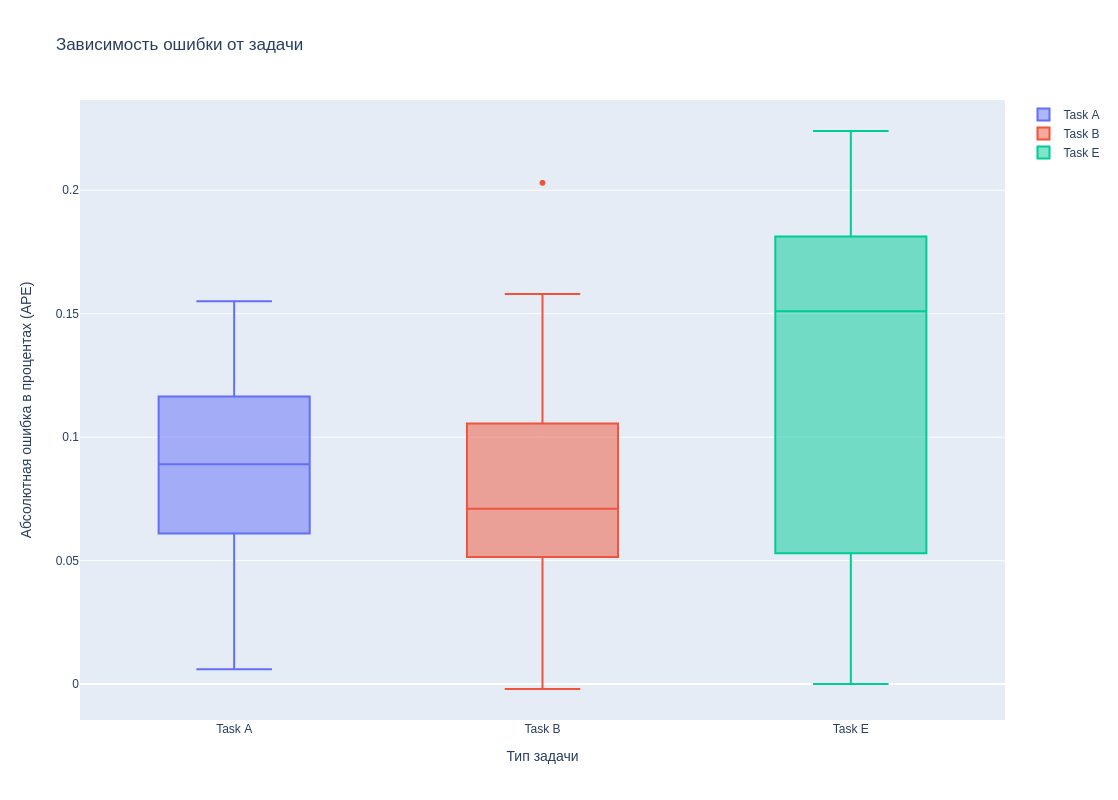

In [38]:
import plotly.graph_objects as go

data_1 = np.array([i[3] for i in results_A_])
data_2 = np.array([i[3] for i in results_B_])
data_3 = np.array([i[3] for i in results_E_])
data = [data_1, data_2, data_3]

fig = go.Figure()

fig.add_trace(go.Box(y=data[0], name='Task A'))
fig.add_trace(go.Box(y=data[1], name='Task B'))
fig.add_trace(go.Box(y=data[2], name='Task E'))

fig.update_layout(title='Зависимость ошибки от задачи',
                  xaxis=dict(title='Тип задачи'),
                  yaxis=dict(title='Абсолютная ошибка в процентах (APE)'))

fig.update_layout(
    autosize=False,
    width=800,
    height=800,
)
fig.show()


In [47]:
def plot_data(data, routes):
    route = copy.deepcopy(routes)
    for arr in routes:
        arr.insert(0,1)
        arr.append(1)
    coordinates = [data['NODE_COORD_SECTION'][i] for i in range(2, data['DIMENSION'] + 1)]
    print(coordinates)
    x, y = zip(*coordinates)
    plt.scatter(x[0:], y[0:], color='blue', marker='o', s=100)
    
    depot_coords = data['NODE_COORD_SECTION'][1]
    plt.scatter(depot_coords[0], depot_coords[1], color='black', marker='s', s=200)
    
    for route in routes:
        route_x, route_y = zip(*[data['NODE_COORD_SECTION'][i] for i in route])
        plt.plot(route_x + (route_x[0],), route_y + (route_y[0],))
            # Add node IDs as annotations
        for i, node_id in enumerate(route):
            plt.annotate(str(node_id), (route_x[i], route_y[i]), textcoords="offset points", xytext=(0, 5), ha='center')
    plt.rcParams["figure.figsize"] = (30,18)
    plt.title("Vehicle Routing Problem Solution")
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.grid(True)
    plt.show()


In [48]:
def plot_map(SET_PROBLEMS="E", index = 3):
    vpr_paths, ans_paths = sets_paths(SET_PROBLEMS)
    print(vpr_paths[index])
    print(ans_paths[index])
    data = read_vpr_file(vpr_paths[index], SET_PROBLEMS)
    solution = read_solution_file(ans_paths[index], SET_PROBLEMS)
    zzz = genetic_algorithm_cvrp(512, data)
    plot_data(data, zzz[0])

E-n23-k3.vrp
E-n23-k3.sol
itter 0 min_value= 617.4085146656088
itter 200 min_value= 569.7461012117925
itter 400 min_value= 569.7461012117925
itter 600 min_value= 569.7461012117925
itter 800 min_value= 569.7461012117925
[(295, 272), (301, 258), (309, 260), (217, 274), (218, 278), (282, 267), (242, 249), (230, 262), (249, 268), (256, 267), (265, 257), (267, 242), (259, 265), (315, 233), (329, 252), (318, 252), (329, 224), (267, 213), (275, 192), (303, 201), (208, 217), (326, 181)]


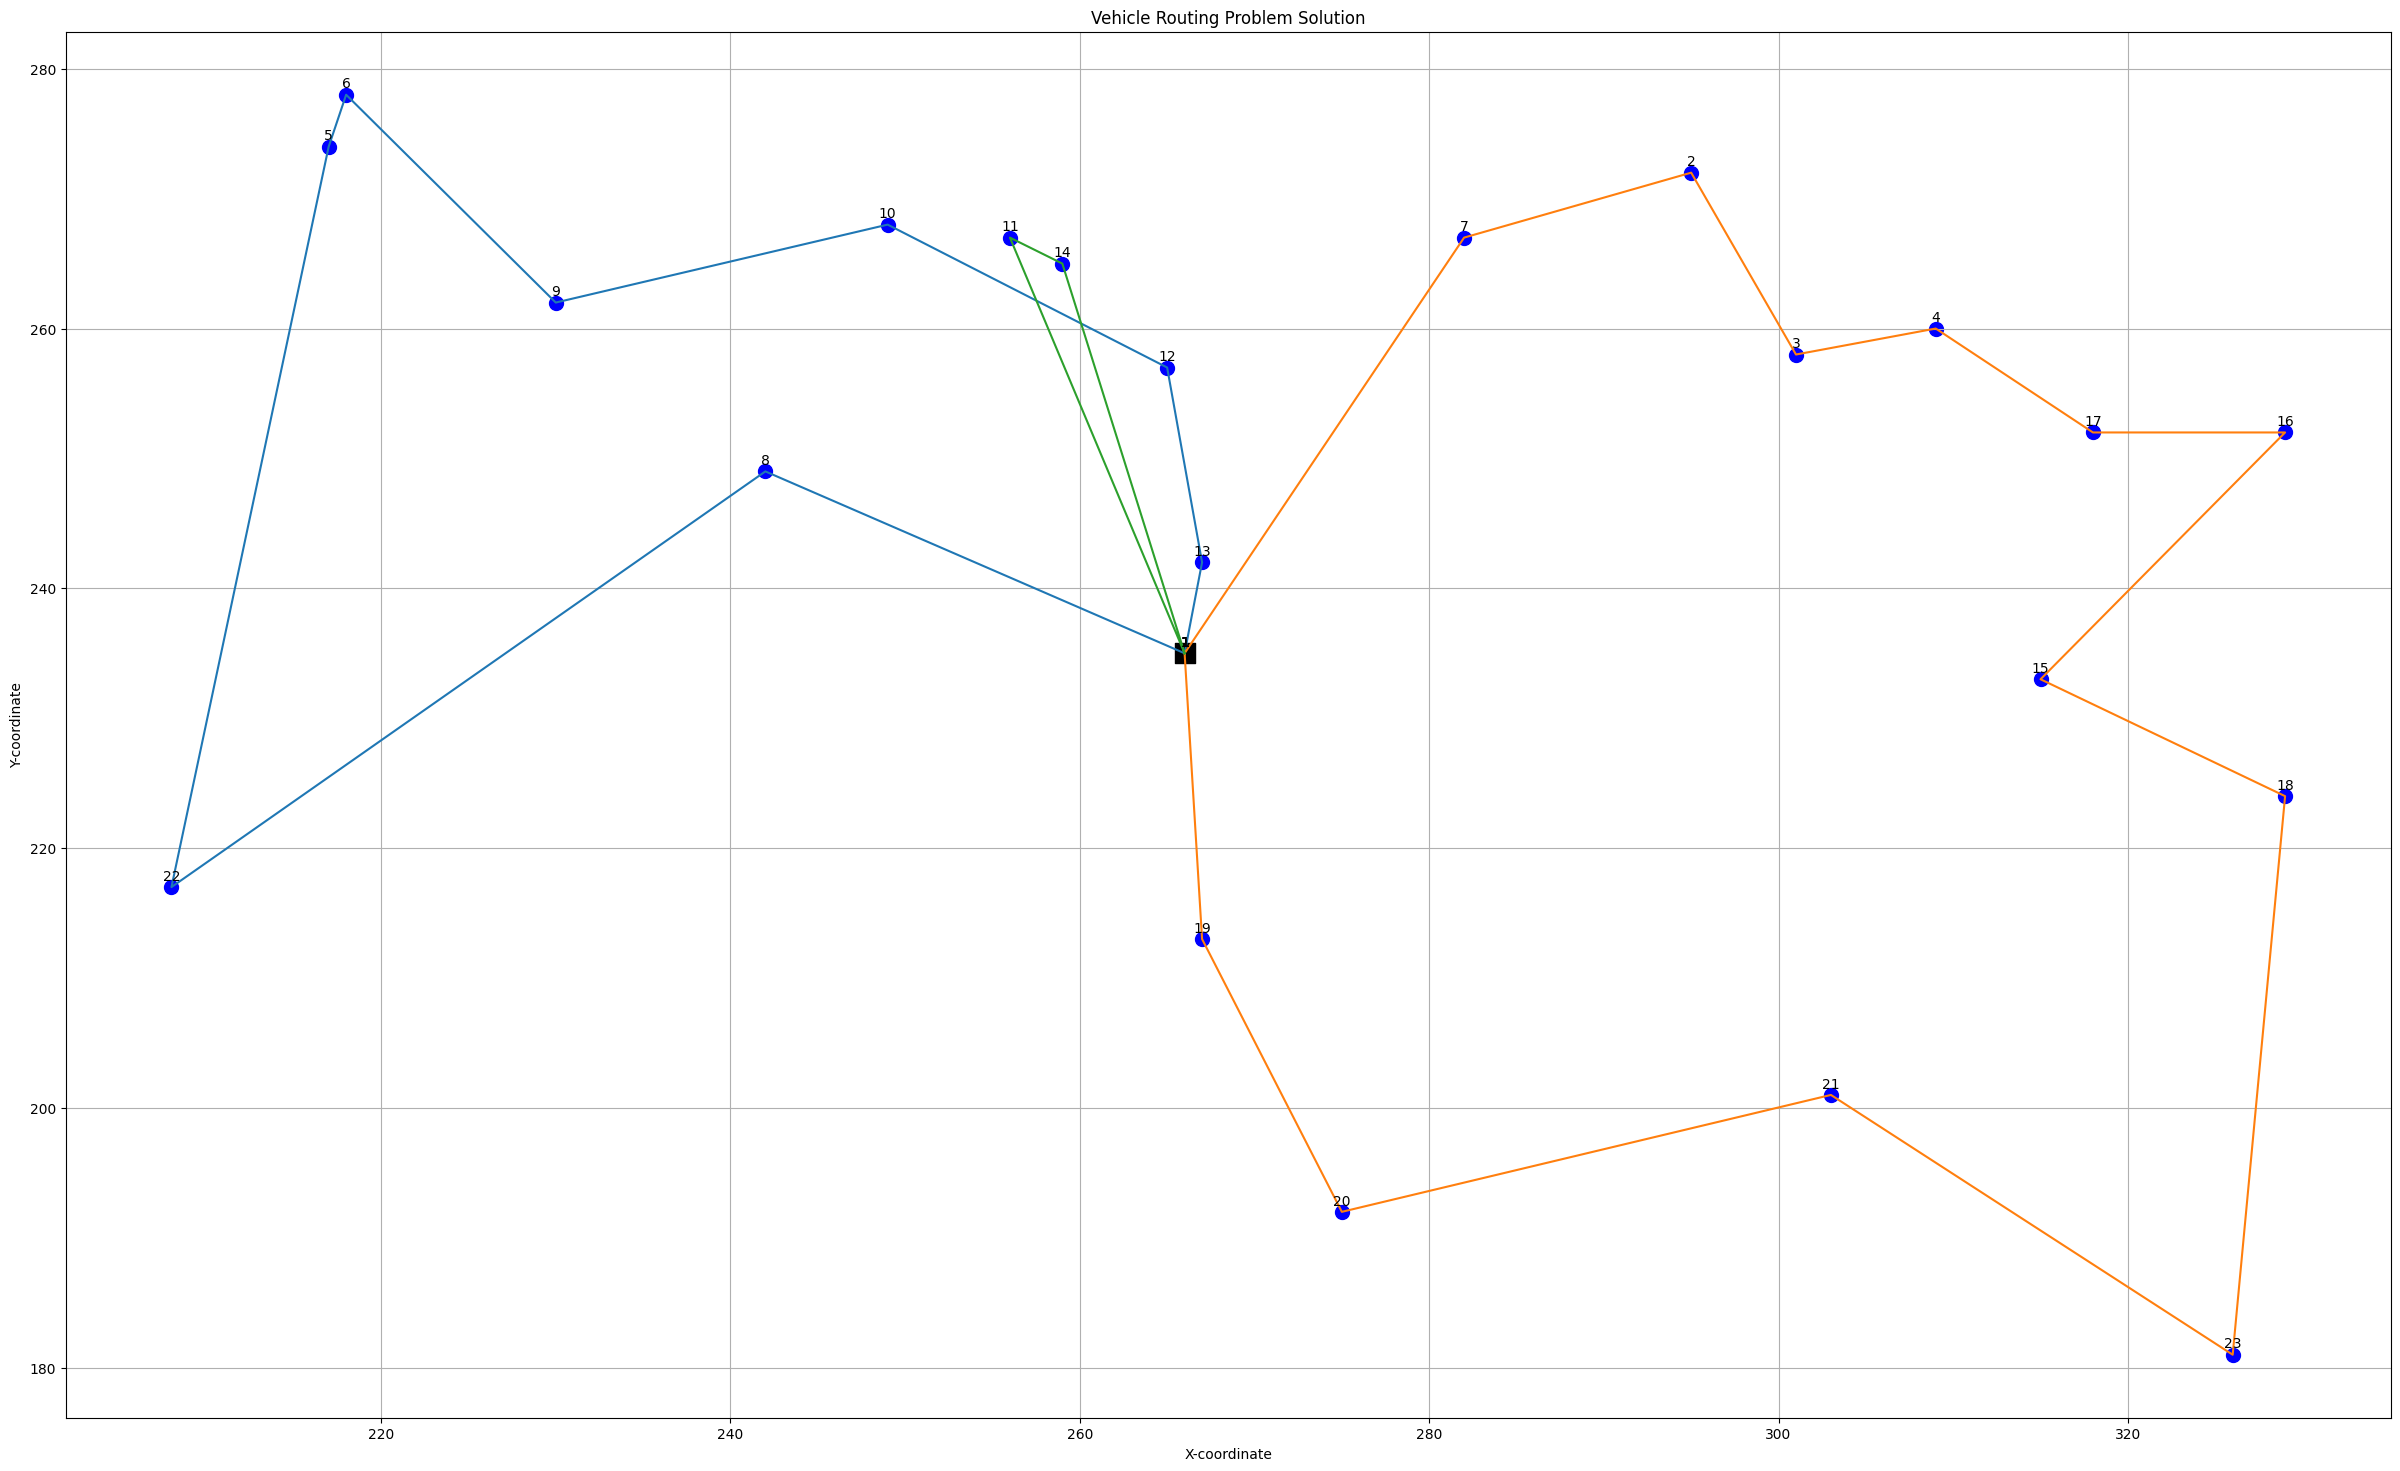

In [49]:
plot_map()

A-n37-k5.vrp
A-n37-k5.sol
itter 0 min_value= 863.8049479524395
itter 200 min_value= 682.5503254474049
itter 400 min_value= 676.3406224567348
itter 600 min_value= 676.212315661969
itter 800 min_value= 676.212315661969
[(59, 46), (96, 42), (47, 61), (26, 15), (66, 6), (96, 7), (37, 25), (68, 92), (78, 84), (82, 28), (93, 90), (74, 42), (60, 20), (78, 58), (36, 48), (45, 36), (73, 57), (10, 91), (98, 51), (92, 62), (43, 42), (53, 25), (78, 65), (72, 79), (37, 88), (16, 73), (75, 96), (11, 66), (9, 49), (25, 72), (8, 68), (12, 61), (50, 2), (26, 54), (18, 89), (22, 53)]


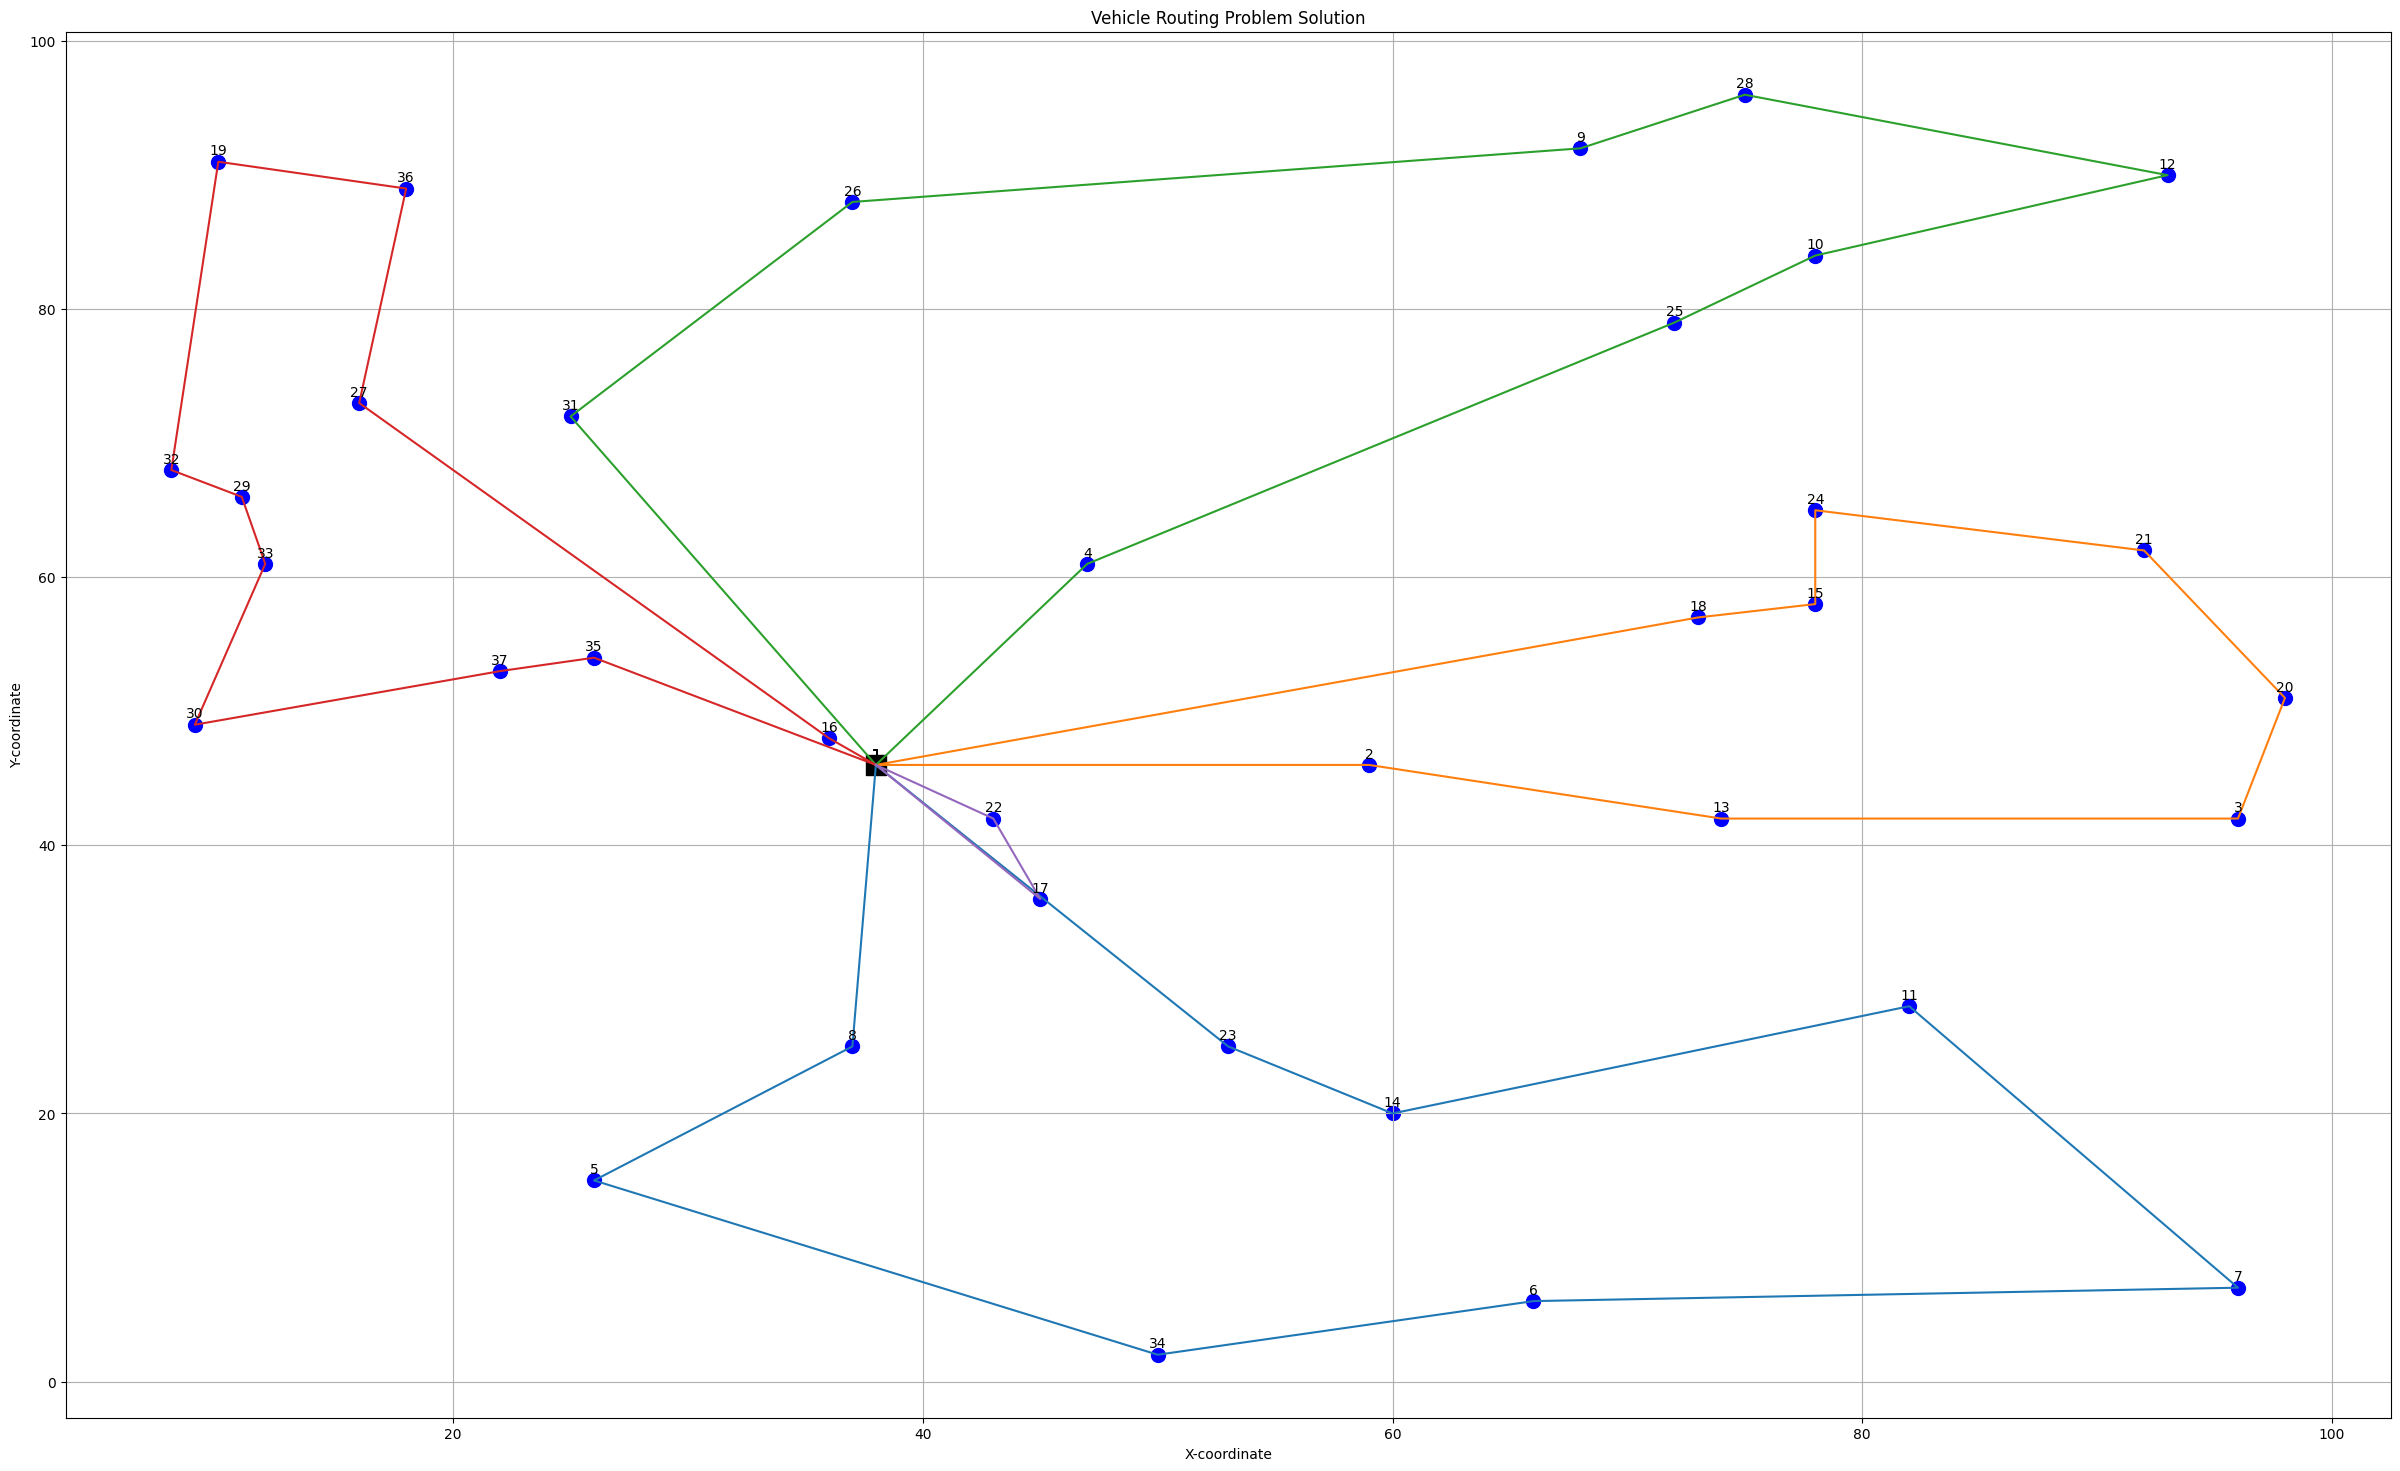

In [50]:
plot_map("A", 5)